In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 1. Define Kalman Filter Function

In [2]:
def kalman_filter(
    y,
    A,
    H,
    P0,
    x0,
    cov_transition,
    cov_observation
):
    # Kalman Filter quantities initialization
    P_pri = P0
    P_post = np.array([])
    x_pri = x0
    x_post = np.array([])
    
    # Shapes
    n_states = len(x0)
    n_obs = y.shape[0]
    
    # Kalman filter loop
    results = pd.DataFrame()
    for k in range(y.shape[-1]):
        
        # Get Kalman gain from a priori estimations
        Q = P_pri@np.transpose(H)@np.linalg.inv(H@P_pri@np.transpose(H) + cov_observation)
        
        # Get a posteriori estimation for x
        x_post = x_pri + Q@(y[:,k] - H@x_pri)
        
        # Get a posteriori error covariance matrix
        P_post = (np.eye(n_states) + Q@H)@P_pri
        
        # Log results for iteration
        results = pd.concat(
            [
                
                results,
                pd.DataFrame(
                    index=[k],
                    data={
                        'iteration': [k+1],
                        'x_prior': [x_pri],
                        'x_posterior': [x_post],
                        'kalman_gain': [Q],
                        'P_prior': [P_pri],
                        'P_posterior': [P_post]
                    }
                )
            ],
            axis=0
        )
        
        # Get a priori state estimate for next iteration
        x_pri = A@x_post
        
        # Get a priori error cov estimate for next iteration
        P_pri = A@P_post@np.transpose(A) + cov_transition
        
    return results

# 2. Create arrays and execute filter

In [3]:
N_ITERS = 100
STATE_NOISE_STD = 1.0
MEAS_NOISE_STD = 1.0
TRANSITION_DAMPING = 0.4

# Transition matrix
A = np.array([
    [TRANSITION_DAMPING, -TRANSITION_DAMPING/3],
    [TRANSITION_DAMPING/5, TRANSITION_DAMPING]
])

A = np.array([
    [0.25, -0.375],
    [1, 0]
])

eigvals, eigvecs = np.linalg.eig(A)
# State noise covariance matrix
state_noise_cov = np.eye(2)*np.square(STATE_NOISE_STD)

# Generate AR(1) states
x_true = [np.random.normal(0, STATE_NOISE_STD, (2,))]
for i, w in enumerate(
    np.random.normal(
        0,
        STATE_NOISE_STD,
        (N_ITERS-1, 2)
    )
):
    x_true.append(
        list(A@np.transpose(x_true[i]) + w.T)
    )

x_true = np.array(x_true).T
    
# Measurement matrix: y will be the difference and sum of AR(1) processes
H = np.array([
    [2, 1],
    [1, 2]
])
H = np.array([
    [1, 0]
])

# Measurement covariance matrix
meas_noise_cov = np.eye(1)*np.square(MEAS_NOISE_STD)

# Generate observed y
y_true = H@x_true + np.random.normal(0, MEAS_NOISE_STD)

In [4]:
# Execute Kalman Filter
res = kalman_filter(
    y=y_true,
    A=A,
    H=H,
    P0=np.eye(2),
    x0=np.array([0, 0]).T,
    cov_transition=state_noise_cov,
    cov_observation=meas_noise_cov
)
res

,iteration,x_prior,x_posterior,kalman_gain,P_prior,P_posterior
0,1,"[0, 0]","[0.5203124002485022, 0.0]","[[0.5], [0.0]]","[[1.0, 0.0], [0.0, 1.0]]","[[1.5, 0.0], [0.0, 1.0]]"
1,2,"[0.13007810006212556, 0.5203124002485022]","[-0.082795804491016, 0.45564184696653515]","[[0.5524475524475524], [0.16783216783216784]]","[[1.234375, 0.375], [0.375, 2.5]]","[[1.9163024475524477, 0.5821678321678322], [0...."
2,3,"[-0.19156464373520468, -0.082795804491016]","[1.0217642525643789, 0.14797371651546584]","[[0.578241559473954], [0.10997885908166614]]","[[1.371025458916084, 0.26076267482517484], [0....","[[2.163809358358214, 0.41154649056868353], [0...."
3,4,"[0.19995091944779503, 1.0217642525643789]","[0.5875149211078696, 1.123543767778339]","[[0.5955037895268777], [0.15638729795983955]]","[[1.4722110469968106, 0.3866224056262971], [0....","[[2.348918304466743, 0.6168575132927546], [0.6..."
4,5,"[-0.2744501826399097, 0.5875149211078696]","[-0.6813262714568855, 0.4899705513758441]","[[0.5975142297299431], [0.14324790899949352]]","[[1.4845598872452737, 0.35590800863190275], [0...","[[2.3716055447606044, 0.568568108264312], [0.5..."
...,...,...,...,...,...,...
95,96,"[-0.21572107513994537, 0.7724861994573617]","[-0.5405558532631352, 0.6911118661180375]","[[0.6052279490889052], [0.15161560335377217]]","[[1.5331073911947386, 0.3840586054758901], [0....","[[2.460986833300572, 0.6165016075980081], [0.6..."
96,97,"[-0.39430591311004787, -0.5405558532631352]","[-1.1021447535768343, -0.7178765025096913]","[[0.6052279490889052], [0.15161560335377214]]","[[1.5331073911947386, 0.38405860547589005], [0...","[[2.460986833300572, 0.616501607598008], [0.61..."
97,98,"[-0.006332499953074333, -1.1021447535768343]","[0.7210640830729453, -0.9199246958630721]","[[0.6052279490889052], [0.15161560335377217]]","[[1.5331073911947386, 0.3840586054758901], [0....","[[2.460986833300572, 0.6165016075980081], [0.6..."
98,99,"[0.5252377817168884, 0.7210640830729453]","[1.1838418207887695, 0.886050926303555]","[[0.6052279490889052], [0.15161560335377214]]","[[1.5331073911947386, 0.38405860547589005], [0...","[[2.460986833300572, 0.616501607598008], [0.61..."


# 3. Show results: estimated vs true states

In [5]:
def proc_results(
    x_true,
    results
):
    res_proc = pd.DataFrame()
    # Get true and estimated (prior, posterior) states in iterations
    for i, row in results.iterrows():
        res_proc = pd.concat(
            [
                res_proc,
                pd.DataFrame(
                    index=[i],
                    data={
                        'iteration': [row['iteration']],
                        'x1_true': x_true[:, i][0],
                        'x2_true': x_true[:, i][1],
                        'x1_prior': [row['x_prior'][0]],
                        'x2_prior': [row['x_prior'][1]],
                        'x1_posterior': [row['x_posterior'][0]],
                        'x2_posterior': [row['x_posterior'][1]],
                    }
                )
            ]
        )
        
    # Plot estimations
    fig, (ax1, ax2) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(20,10)
    )
    
    # X1
    ax1.plot(
        res_proc['iteration'].values,
        res_proc['x1_true'].values,
        label='true'
    )
    ax1.scatter(
        res_proc['iteration'].values,
        res_proc['x1_prior'].values,
        marker='X',
        color='red',
        label='prior'
    )
    ax1.plot(
        res_proc['iteration'].values,
        res_proc['x1_posterior'].values,
        linestyle='--',
        marker='x',
        label='posterior'
    )
    ax1.legend()
    ax1.set_title('x1')
    
    # X2
    ax2.plot(
        res_proc['iteration'].values,
        res_proc['x2_true'].values,
        label='true'
    )
    ax2.scatter(
        res_proc['iteration'].values,
        res_proc['x2_prior'].values,
        marker='X',
        color='red',
        label='prior'
    )
    ax2.plot(
        res_proc['iteration'].values,
        res_proc['x2_posterior'].values,
        marker='x',
        linestyle='--',
        label='posterior'
    )
    ax2.legend()
    ax2.set_title('x2')
        
    return res_proc

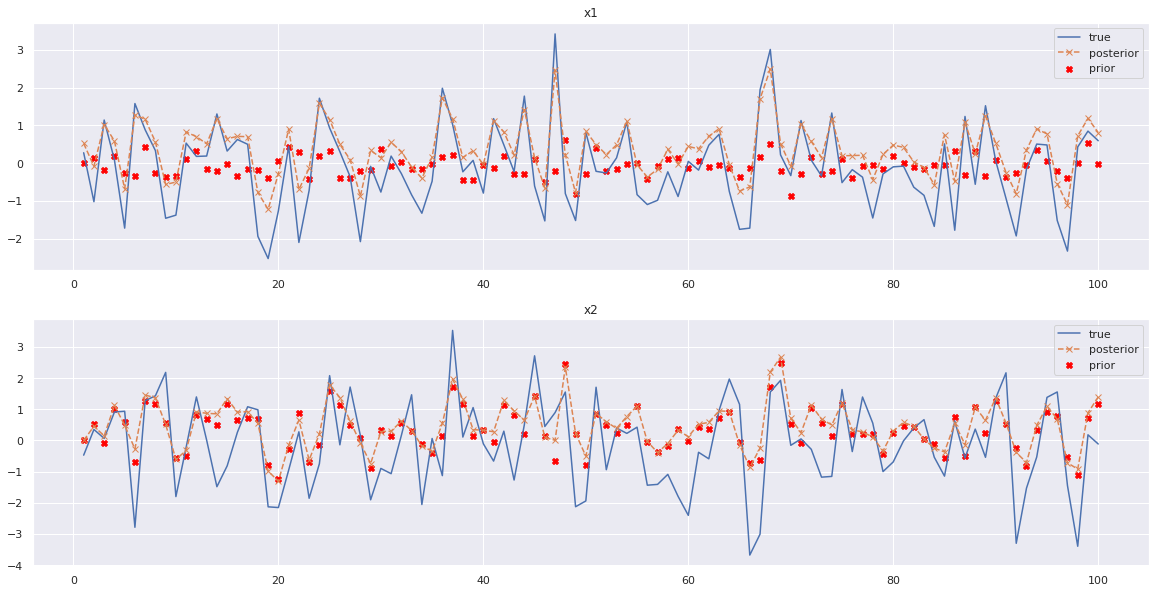

In [6]:
proc_results = proc_results(
    x_true=x_true,
    results=res
)